In [115]:
import skimage as sk 
from skimage import io 
import cv2 
import numpy as np 
from matplotlib import pyplot as plt 
from numpy import fft
from scipy import ndimage
from scipy.signal import gaussian, convolve
from skimage.transform import radon, iradon

In [2]:
def read_img(im_name, to_float=False):
    im = io.imread(im_name)
    if to_float:
        im = sk.img_as_float(im).astype("float32")
    return im 

def normalize(im, to_int=False):
    normalized = (im.copy()-im.min())/(im.max()-im.min()+1e-8)
    if to_int:
        normalized = np.clip(normalized, 0, 1)
        normalized = (255*normalized).astype("uint8")
    return normalized

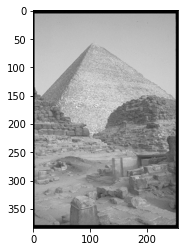

In [81]:
pyramid = read_img('./Pyramid.bmp', True)
plt.imshow(pyramid, cmap='gray')

(544, 180)

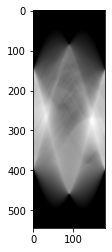

In [157]:
theta = np.linspace(0., 180., 180, endpoint=False)
sinogram = radon(pyramid, theta=theta, circle=False)
plt.imshow(sinogram, cmap='gray')
sinogram.shape

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


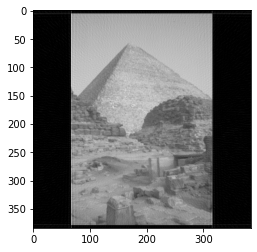

In [158]:
reconstruction_fbp = iradon(sinogram, theta=theta, circle=False)
reconstruction_fbp = np.clip(reconstruction_fbp, 0, 1)
plt.imshow(reconstruction_fbp, cmap='gray')
io.imsave('./ConvBack.bmp', reconstruction_fbp)

In [161]:
interp_lst = ['linear', 'nearest', 'cubic']
lst = [iradon(sinogram, theta=theta, circle=False, interpolation=interp) for interp in interp_lst]
lst = [np.clip(l, 0, 1) for l in lst]

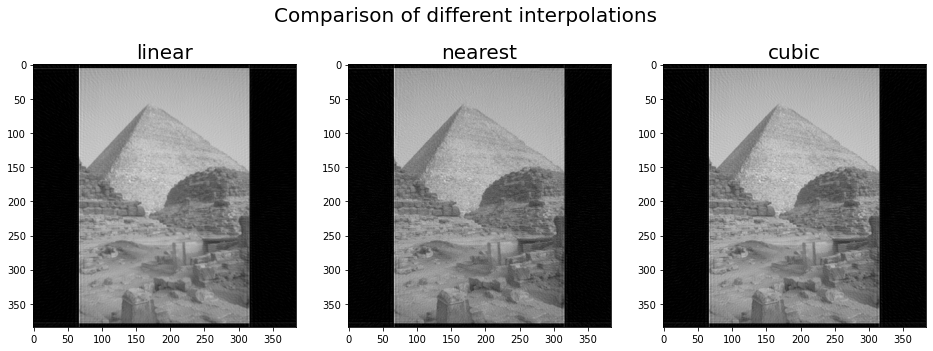

In [162]:
f, axarr = plt.subplots(1, 3)
fig = plt.gcf()
fig.set_size_inches(16, 5.5)
fig.suptitle('Comparison of different interpolations', fontsize=20)
"""It's hard to tell the difference at a glance
   but if we zoom in, we can see that 
   compared to linear, nearest is not as smooth and 
   has the most artifacts in the sky and corners. 
   cubic looks looks the best, mored detailed 
   compared to linear, but it also runs 
   the slowest"""
for i, interp in enumerate(interp_lst):
    axarr[i].imshow(lst[i], cmap='gray')
    axarr[i].set_title(interp, fontsize=20)

In [167]:
filter_lst = [None, 'ramp', 'shepp-logan', 'cosine', 'hamming', 'hann']
lst = [iradon(sinogram, theta=theta, circle=False, filter_name=filter_name) for filter_name in filter_lst]
lst = [lst[0]] + [np.clip(l, 0, 1) for l in lst[1:]]

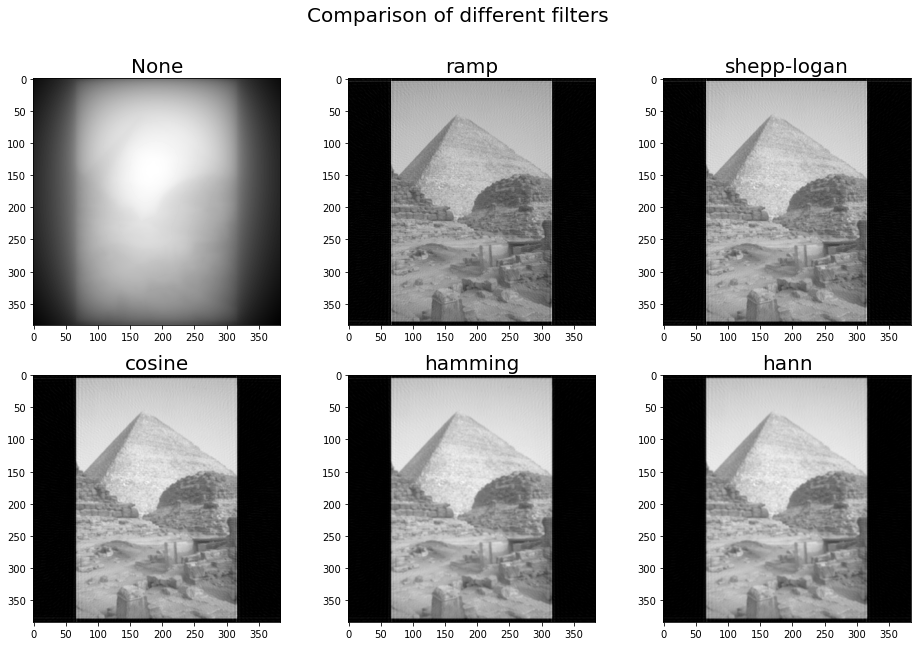

In [168]:
f, axarr = plt.subplots(2, 3)
fig = plt.gcf()
fig.set_size_inches(16, 10)
fig.suptitle('Comparison of different filters', fontsize=20)
"""None(no filter) is way too blurry compared to others, 
   which is not acceptable. Applying filters greatly 
   improve the performance. ramp is the most blurry one. 
   ringing effect exists if using ramp, shepp-logan, cosine
   and less severe in hamming and hann
   hamming looks slightly smoother, but not as clear
   similar to hann and it has even less aliases
   for the rest of them. ramp is a bit dark. while others
   are brighter. shepp-logan is also a bit dark so 
   its artifacts in the sky appear more noticeable. 
   but its pyamid is the most detailed/clear one. 
   cosine looks neutral in every aspects. 
   """
for i, filt in enumerate(filter_lst):
    r, c = i//3, i%3
    axarr[r, c].imshow(lst[i], cmap='gray')
    axarr[r, c].set_title(str(filt), fontsize=20)

In [202]:
def less_sample(im, factor):
    theta = np.linspace(0., 180., 180, endpoint=False)
    sinogram = radon(im, theta=theta, circle=False)
    sinogram = sinogram[::factor]
    reconstruction_fbp = iradon(sinogram, theta=theta, circle=False)
    plt.imshow(reconstruction_fbp, cmap='gray')
    io.imsave('./ConvBack'+str(factor)+'.bmp', reconstruction_fbp)

Lossy conversion from float64 to uint8. Range [-0.23767413976132012, 1.3785578770198736]. Convert image to uint8 prior to saving to suppress this warning.


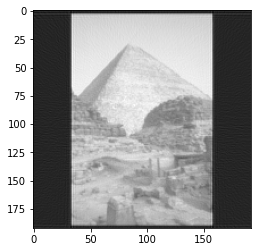

In [203]:
"""It starts to show some artifacts on the stright lines"""
less_sample(pyramid, 2)

Lossy conversion from float64 to uint8. Range [-0.8240267232416765, 3.3943958244827273]. Convert image to uint8 prior to saving to suppress this warning.


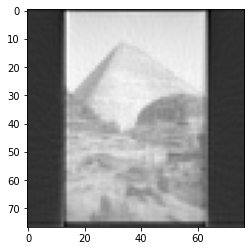

In [205]:
less_sample(pyramid, 5)
# even more artifacts, very noticeable and noisy
# and blurry

In [142]:
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return rho, phi

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return x, y

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

fft = np.fft.fft2(pyramid)
shifted = np.fft.fftshift(fft)
d, theta = cart2pol(np.real(shifted), np.imag(shifted))
theta_range = np.linspace(-np.pi, np.pi, 465)
H, W = theta.shape
flatten = theta.reshape((-1))
rounded = np.zeros(flatten.shape)
for i in range(H*W):
    rounded[i] = find_nearest(theta_range, flatten[i])
rounded = rounded.reshape((H, W))
real, imag = pol2cart(d, rounded)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


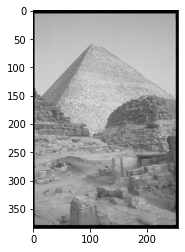

In [146]:
"""Compared to iradon, it is not as smooth. 
   with noticeable artifects on the stright lines"""
nearest = np.vectorize(complex)(real, imag)
x = np.fft.ifft2(np.fft.fftshift(nearest))
x = np.real(x) + np.imag(x)
reconstructed = np.clip(x, 0, 1)
plt.imshow(reconstructed, cmap='gray')
io.imsave('./Polar.bmp', reconstructed)